In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animal-faces:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F667852%2F1176357%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240618%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240618T090734Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D23fbe4fcecfb642991e78fcd8698bd1fad9a648454ecf110cc7ae58739c2818b6070ad935a43eddfd6836ab15783f0355ad575081c92f3cde860e2ee40de31f05b9a06c6ec20895bfeb6dbfb6dd4c776921ee2ad69524c3137d90fa9bda0cec0cecb5c49109ab6fd0baa5e8d0bd50e14190cb9ad9b029385933aaba36ed272cb26152c70073d601b7a6a2482a20d907c640bdab1b7f90cd544547fba114d0a845918e41b66acff4549c05b54f0523dc660a3e02f711e5be3cac13d5d7b0d2dea27297363337fea7a9f97bb1ffd0c4ef1577b3de24f26f310f983f13d81f4d3509e6a3b7a5d0303790600ee51517e3361ae9ff10dec4ff18b5e04895932c71ec6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 729700755 bytes downloaded
Downloaded and uncompressed: animal-faces
Data source import complete.


# Introduction
Hey people, welcome to this kernel. In this kernel I'm gonna show you how to build a convolutional neural network using Pytorch.

I used to work with Tensorflow, but recently I decided to change my main deep learning library as Pytorch. I've researched both Tensorflow and Pytorch (really) detailed and Pytorch seems better for me.

So let's start!

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

# Preparing Dataset
Pytorch offers advanced tools for reading,batching and preparing image data and today we'll use those tools.

In general, preparing data in pytorch have 3 steps.

**1. Preparing Dataset Class**

**2. Preparing Sampler**

**3. Preparing Data Loader**


### 1. Preparing Dataset Class
First, we'll create a dataset class by inheriting our class Pytorch's abstract Dataset class. There are some special functions we must override. We'll see them in the code.

In [3]:
# * We'll use this class to control the things.
class InvalidDatasetException(Exception):

    def __init__(self,len_of_paths,len_of_labels):
        super().__init__(
            f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})"
        )

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
class AnimalDataset(Dataset):

    def __init__(self,img_paths,img_labels,size_of_images):
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.size_of_images = size_of_images
        if len(self.img_paths) != len(self.img_labels):
            raise InvalidDatasetException(self.img_paths,self.img_labels)


    # We need to override __len__ special method
    def __len__(self):
        return len(self.img_paths)

    # Also we need to override __getitem__ special method
    # This method should return the image and its label from index given.
    def __getitem__(self,index):
        PIL_IMAGE = Image.open(self.img_paths[index]).resize(self.size_of_images)
        # In pytorch we use torch tensors, ToTensor transform transforms the PIL image
        # to Torch tensor.
        TENSOR_IMAGE = transform(PIL_IMAGE)
        label = self.img_labels[index]

        return TENSOR_IMAGE,label

* If we want briefly explain what does this class do, it reads the image and convert it to a Torch tensor. Then it returns the image and the label of the image.

* Let's create our object.

In [6]:
paths = []
labels = []
label_map = {0:"Cat",
             1:"Dog",
             2:"Wild"
            }

for cat_path in glob("../input/animal-faces/afhq/train/cat/*") + glob("../input/animal-faces/afhq/val/cat/*"):
    paths.append(cat_path)
    labels.append(0)

for dog_path in glob("../input/animal-faces/afhq/train/dog/*") + glob("../input/animal-faces/afhq/val/dog/*"):
    paths.append(dog_path)
    labels.append(1)

for wild_path in glob("../input/animal-faces/afhq/train/wild/*") + glob("../input/animal-faces/afhq/val/wild/*"):
    paths.append(wild_path)
    labels.append(2)

print(len(paths))
print(len(labels))

16130
16130


In [7]:
dataset = AnimalDataset(paths,labels,(250,250))

* We've completed the hardest part of preparing data. Now we'll create our sampler object.
* Basically sampler shows how we'll choose the data.
* We'll create two random samplers: Train Random Sampler and Test Random Sampler.
* These random samplers will randomly choose indices from the list given. You'll definitely understand when you see. Let's code it.

### 2. Preparing Sampler Objects

In [8]:
from sklearn.model_selection import train_test_split

# dataset_indices = [0,1,2,3,..len(dataset)-1]
dataset_indices = list(range(0,len(dataset)))

train_indices,test_indices = train_test_split(dataset_indices,test_size=0.2,random_state=42)
print("Number of train samples: ",len(train_indices))
print("Number of test samples: ",len(test_indices))

Number of train samples:  12904
Number of test samples:  3226


* And now all we need to do is giving these indices lists to our samplers.

In [9]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

### 3. Preparing Data Loader Objects
Everything is ready to combine. We have a dataset we can read images and labels. We have samplers which will help us to randomly choose samples. And now we need a data loader which will create batches using the dataset and samplers.

In [10]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=test_sampler)

* Everything is ready about data. Let's move on to the neural network modeling.


But before, let's take a look at our images.

In [11]:
dataset[1][0].shape

torch.Size([3, 250, 250])

In [12]:
images,labels = next(iter(train_loader))
type(labels)

torch.Tensor

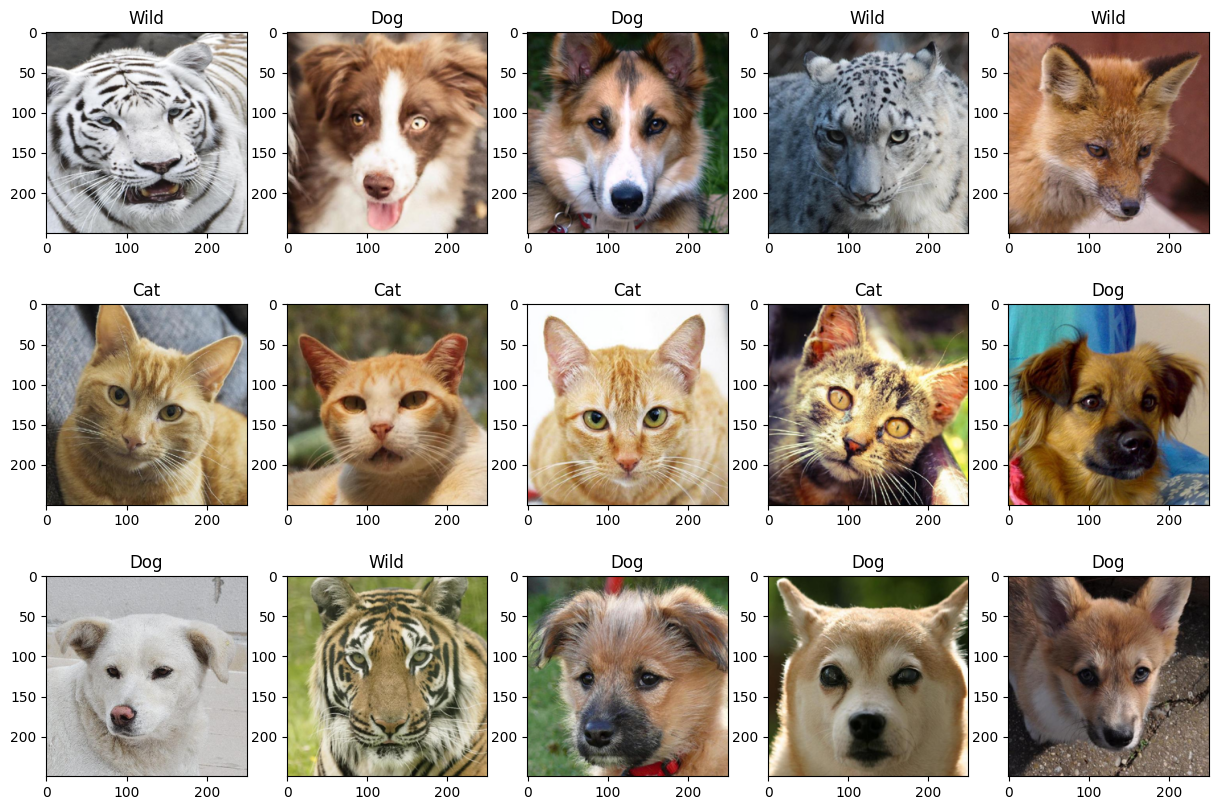

In [13]:
images,labels = next(iter(train_loader))

fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        npimg = images[i].numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        label = label_map[int(labels[i])]
        ax.imshow(npimg)
        ax.set(title = f"{label}")


# Neural Network Modeling
Our dataset is ready, now we can build our deep convolutional neural network. In Pytorch, when we build a model, we create a class inherited Pytorch's nn.Module abstract class.

Then we need to write forward function which includes forward propagation.

In [14]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN,self).__init__()
        # First we'll define our layers
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)

        self.maxpool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(256 * 2 * 2,512)
        self.fc2 = nn.Linear(512,3)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        x = F.relu(self.conv4(x))
        x = self.batchnorm3(x)
        x = self.maxpool(x)
        x = x.view(-1, 256 * 2 * 2)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x



* Now we can create our model object.
* But before we need to create our GPU variable, we'll send our model to the gpu that way.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
device

device(type='cuda')

In [17]:
model = CNN().to(device)

Also as you know, in deep learning we use an optimization algorithm to apply gradients and a loss function to compute gradients. In this kernel we're going to use cross entropy loss and RMSProp optimizer.

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr=1e-4)

# Training Model
Our model and dataset are ready, now we can train our model.

In [19]:
EPOCH_NUMBER = 5
TRAIN_LOSS = []
TRAIN_ACCURACY = []

for epoch in range(1,EPOCH_NUMBER+1):
    epoch_loss = 0.0
    correct = 0
    total = 0
    for data_,target_ in train_loader:
        # We have to one hot encode our labels.
        target_ =target_.to(device)
        data_ = data_.to(device)

        # Cleaning the cached gradients if there are
        optimizer.zero_grad()

        # Getting train decisions and computing loss.
        outputs = model(data_)
        loss = criterion(outputs,target_)

        # Backpropagation and optimizing.
        loss.backward()
        optimizer.step()

        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        correct = correct + torch.sum(pred == target_).item()
        total += target_.size(0)

    # Appending stats to the lists.
    TRAIN_LOSS.append(epoch_loss)
    TRAIN_ACCURACY.append(100 * correct / total)
    print(f"Epoch {epoch}: Accuracy: {100 * correct/total}, Loss: {epoch_loss}")


Epoch 1: Accuracy: 83.99721016738995, Loss: 47.48510713875294
Epoch 2: Accuracy: 95.58276503409796, Loss: 13.424369245767593
Epoch 3: Accuracy: 98.03936763794172, Loss: 6.8402514308691025
Epoch 4: Accuracy: 99.40328580285183, Loss: 2.9539066618308425
Epoch 5: Accuracy: 99.68226906385617, Loss: 1.528437198838219


**We've trained our model, and now we can take a look at the stats and after that we can evaluate our model by using test set.**

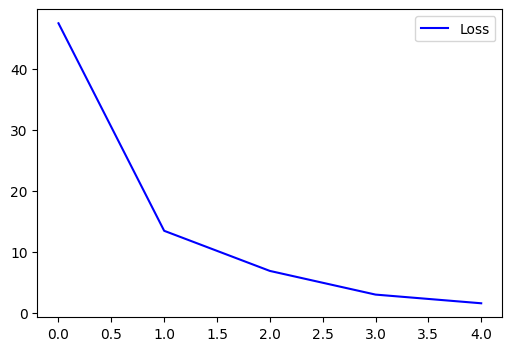

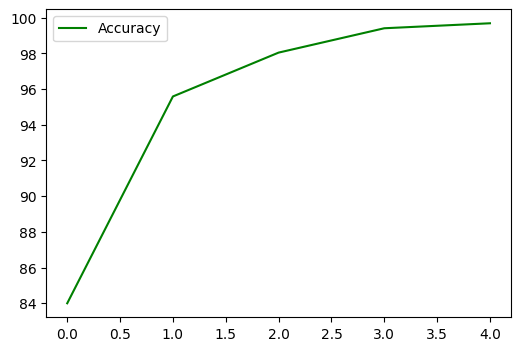

In [20]:
plt.subplots(figsize=(6,4))
plt.plot(range(EPOCH_NUMBER),TRAIN_LOSS,color="blue",label="Loss")
plt.legend()
plt.show()

plt.subplots(figsize=(6,4))
plt.plot(range(EPOCH_NUMBER),TRAIN_ACCURACY,color="green",label="Accuracy")
plt.legend()
plt.show()

# Final Test
And now we'll test our model using our test loader.

In [ ]:
total_val_loss = 0.0
total_true = 0
total = len(test_sampler)

# When we're not working with gradients and backpropagation
# we use torch.no_grad() utility.
with torch.no_grad():
    model.eval()
    for data_,target_ in validation_loader:
        data_ = data_.to(device)
        target_ = target_.to(device)

        outputs = model(data_)
        loss = criterion(outputs,target_).item()
        _,preds = torch.max(outputs,dim=1)
        total_val_loss += loss
        true = torch.sum(preds == target_).item()
        total_true += true

validation_accuracy = round(100 * total_true / total,2)
print(f"Validation accuracy: {validation_accuracy}%")
print(f"Validation loss: {round(total_val_loss,2)}%")

* And boom, our model is ready to use!

# How to Save A Pytorch Model
We trained our model and we might want to use it in our real life. And in order to use it regularly we need to save it.

There are lots of way to save a model in Pytorch but today we'll use the best way: saving state dict.


State dictionary is a python dictionary which includes layer names as keys and layer weights as items. If we take a look at the state dict we can fully understand it.

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

* And as you guess, we can just save and load this state dict.

In [ ]:
torch.save(model.state_dict(),"model.pt")


* And in order to load model we need to create a new object from the class and load the state dict.

In [ ]:
loaded_model = CNN()
loaded_model.load_state_dict(torch.load("model.pt"))


# Conclusion
Thanks for your attention. If you have a question, plase share it with me. It's a pleasure for me to help you. Have a good day!